In [1]:
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from numpy import trapz

In [2]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    print(x)
    print(y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [3]:
data = pd.read_json("datasetTest100k.json", typ="frame", lines = True, precise_float=True,nrows = 5*100000)

In [4]:
#from RealisticDataExplorer.ipynb
trkData = np.stack(data[3],axis=0)

trk_high_level_name = ["track_2_d0_significance", "track_3_d0_significance",
                       "track_2_z0_significance", "track_3_z0_significance",
                       "n_tracks_over_d0_threshold", "jet_prob", "jet_width_eta", "jet_width_phi"]

for i, trkName in enumerate(trk_high_level_name):
    tmpArr = np.array(trkData[:,i],dtype="float32")
    data[trkName] = tmpArr

vtxData = np.stack(data[4],axis=0)
    
vtx_high_level_name = ["vertex_significance", "n_secondary_vertices", "n_secondary_vertex_tracks",
                       "delta_r_vertex", "vertex_mass", "vertex_energy_fraction"]

for i, vtxName in enumerate(vtx_high_level_name):
    tmpArr = np.array(vtxData[:,i],dtype="float32")
    data[vtxName] = tmpArr

# Smeared Data    
trk_high_level_smear = [{"name":"track_2_d0_significance","mu":0,"sigma":1.5,"index":0},
                        {"name":"track_3_d0_significance","mu":0,"sigma":2.5,"index":1},
                        {"name":"track_2_z0_significance","mu":0,"sigma":1.5,"index":2},
                        {"name":"track_3_z0_significance","mu":0,"sigma":2.5,"index":3},
                        #"n_tracks_over_d0_threshold"
                        #"jet_prob", 
                        {"name":"jet_width_eta","mu":0,"sigma":0.05,"index":6},
                        {"name":"jet_width_phi","mu":0,"sigma":0.05,"index":7}
                       ]

for trkSmear in trk_high_level_smear:
    tmpArr = np.array(trkData[:,trkSmear["index"]],dtype="float32")
    data[trkSmear["name"]+"_smear"] = (tmpArr**2 + 
                                     np.random.normal(trkSmear["mu"], trkSmear["sigma"], tmpArr.size)**2)**0.5    

In [5]:
data

,0,1,2,3,4,5,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,...,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction,track_2_d0_significance_smear,track_3_d0_significance_smear,track_2_z0_significance_smear,track_3_z0_significance_smear,jet_width_eta_smear,jet_width_phi_smear
0,47.8712,1.893250,5,"[21.1765, 8.36586, 29.0269, 4.149, 5, 2.68624e...","[32.8902, 3, 7, 0.162448, 1.59408, 0.862678]","[[[0.0311627, 0.0820037, 0.0714865, 0.0122187,...",21.176500,8.365860,29.026899,4.149000,...,7.0,0.162448,1.594080,0.862678,21.176636,8.737018,29.167902,4.151955,0.079242,0.064368
1,34.9703,0.609755,5,"[5.0077, 3.03583, 2.00754, 0.329921, 3, 1.7627...","[25.1935, 1, 3, 0.122343, 2.23962, 0.930327]","[[[-0.0290837, 0.122745, 0.311415, 0.054644, -...",5.007700,3.035830,2.007540,0.329921,...,3.0,0.122343,2.239620,0.930327,5.122695,3.372843,2.395390,0.651690,0.066886,0.151584
2,26.5706,-0.530268,5,"[0.807884, 0.630565, 1.04452, 1.28336, 0, 0.04...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00689455, -0.379085, 0.0617111, -0.02322...",0.807884,0.630565,1.044520,1.283360,...,-1.0,inf,-1.000000,-inf,1.629012,0.681312,1.629245,4.375228,0.136303,0.114084
3,36.9246,-2.074420,5,"[16.5617, 10.357, 17.5166, 30.4992, 4, 4.35319...","[73.6335, 1, 2, 0.259107, 0.755648, 0.594634]","[[[0.0183914, -0.00212568, -0.0371647, -0.0217...",16.561701,10.357000,17.516600,30.499201,...,2.0,0.259107,0.755648,0.594634,16.757563,10.945738,17.521402,30.532671,0.173301,0.124375
4,28.9667,1.512090,5,"[18.0325, 16.1445, 3.29359, 9.00347, 4, 3.3143...","[293.79, 1, 4, 0.0871323, 1.40008, 1.00014]","[[[-0.753196, 3.5972, -0.11093, 0.0896224, -0....",18.032499,16.144501,3.293590,9.003470,...,4.0,0.087132,1.400080,1.000140,18.081702,16.235465,3.566746,9.006951,0.089978,0.096234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,27.9514,-1.952300,0,"[0.594449, -inf, 0.17506, -inf, 0, 0.0520256, ...","[-1, -1, -1, inf, -1, -inf]","[[[0.0148769, -0.0165837, 0.0171593, 0.0010783...",0.594449,-inf,0.175060,-inf,...,-1.0,inf,-1.000000,-inf,2.568998,inf,2.080435,inf,0.174309,0.119625
199996,31.7411,0.581113,0,"[0.884008, 0.0586451, 2.08934, 1.0856, 1, 4.22...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00236544, 0.264679, 0.0364315, 0.115328,...",0.884008,0.058645,2.089340,1.085600,...,-1.0,inf,-1.000000,-inf,1.140558,0.239039,2.589685,1.161362,0.157456,0.100816
199997,43.4182,-1.354190,0,"[2.01423, 0.0571862, 0.018169, 0.646206, 2, 0....","[-1, -1, -1, inf, -1, -inf]","[[[-0.0641859, -0.00209336, -0.0657659, -0.005...",2.014230,0.057186,0.018169,0.646206,...,-1.0,inf,-1.000000,-inf,3.646003,1.127102,1.284224,0.821634,0.113691,0.069251
199998,25.8566,-2.288910,0,"[1.1272, 0.794378, 0.415697, 0.0726794, 0, 0.0...","[-1, -1, -1, inf, -1, -inf]","[[[-0.0150902, 0.204454, -0.3825, -0.0139872, ...",1.127200,0.794378,0.415697,0.072679,...,-1.0,inf,-1.000000,-inf,1.230843,3.232211,2.270799,0.181270,0.098209,0.106160


In [6]:
y = data[2]
y = y.values.tolist()

for i in range(len(y)):
    if y[i]==5:
        y[i]=1
    else:
        y[i]=0

In [7]:
jets_trk = []
for i in range(0,200000):
    trkVars = []
    for j in range(len(data[5][i])):
        trkVars.append(data[5][i][j][0])
    jets_trk.append(trkVars)

In [8]:
d0 = []
for i in jets_trk:
    temp = []
    for j in i:
        temp.append(j[0])
    d0.append(temp)

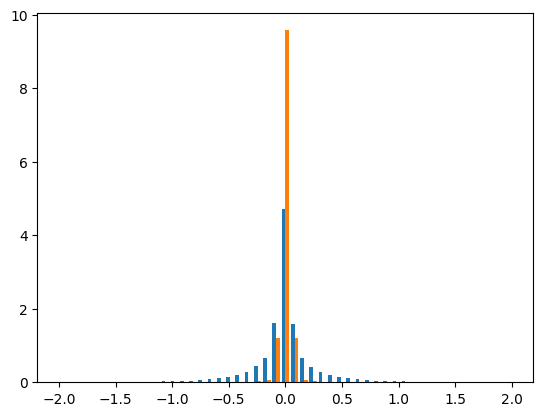

In [9]:
bj=[]
lf=[]
for i in range(len(y)):
    assert len(d0)==len(y)
    if y[i]==1:
        bj.append(d0[i])
    else:
        assert y[i]==0
        lf.append(d0[i])

def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat
bj_d0_flat = flatten(bj)
lf_d0_flat = flatten(lf)
counts, bins, _ = plt.hist([bj_d0_flat,lf_d0_flat], bins=np.linspace(-2,2,50),density=True)

In [10]:
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)): 
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi) 
    return p

def Poissonlikelihood(test, train_hist_counts, train_hist_bins, lenCount, lenBins):
    p=[]
    for i in test:
        pi=probInHist(len(i),lenCount,lenBins)
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

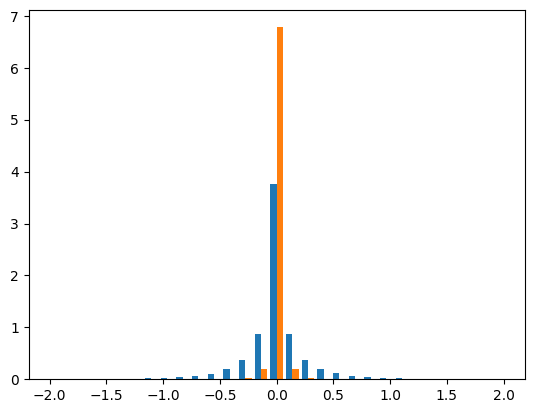

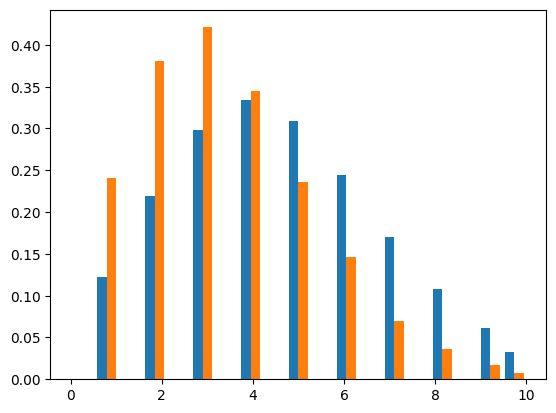

In [11]:
#likelihood on low level d0
d0_bj_train = bj[0:50000]
d0_lf_train = lf[0:50000]
d0_bj_test = bj[50000:len(bj)]
d0_lf_test = lf[50000:len(lf)]

#plot the distributions:
LCounts, Lbins, _ =plt.hist([flatten(d0_bj_train),flatten(d0_lf_train)], bins=np.linspace(-2,2,30), density=True)
plt.show()
#plot dimentions distribution:
length_bj=[]
length_lf=[]
for i in d0_bj_train:
    length_bj.append(len(i))
for i in d0_lf_train:
    length_lf.append(len(i))

lengthcounts,lengthbins, _=plt.hist([length_bj,length_lf], bins=np.linspace(0,10,20), density=True)
plt.show()

prob_bj=Poissonlikelihood(d0_bj_test,LCounts,Lbins,lengthcounts,lengthbins)
prob_lf=Poissonlikelihood(d0_lf_test,LCounts,Lbins,lengthcounts,lengthbins)


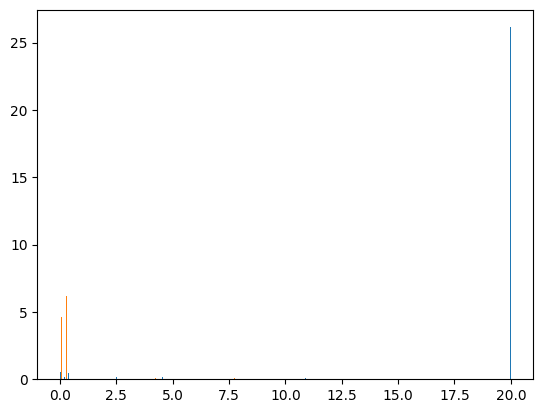

In [12]:
for i in range(len(prob_bj)):
    if prob_bj[i]>20:
        prob_bj[i]=20
    
for i in range(len(prob_lf)):
    if prob_lf[i]>20:
        prob_lf[i]=20

llhcounts, llhbins, _ =plt.hist([prob_bj,prob_lf],bins=np.linspace(0,20,1000),density=True)
plt.show()

(array([[0.0000e+00, 1.9513e+04, 0.0000e+00, 1.4356e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 8.4410e+03, 0.0000e+00,
         1.5200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.9000e+01, 0.0000e+00, 3.5000e+01, 2.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 2.1000e+01,
         7.5000e+01, 0.0000e+00, 1.7400e+02, 0.0000e+00, 4.3000e+02,
         3.3150e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 3.3000e+01, 7.1000e+01,
         3.0000e+00, 1.1000e+02, 1.8630e+03, 4.8000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.5200e+02, 4.2614e+04],
        [0.0000e+00, 7.2030e+04, 0.0000e+00, 2.5194e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2400e+03, 0.0000e+00,
         2.3600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+01, 0.0000e+00, 2.7000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 

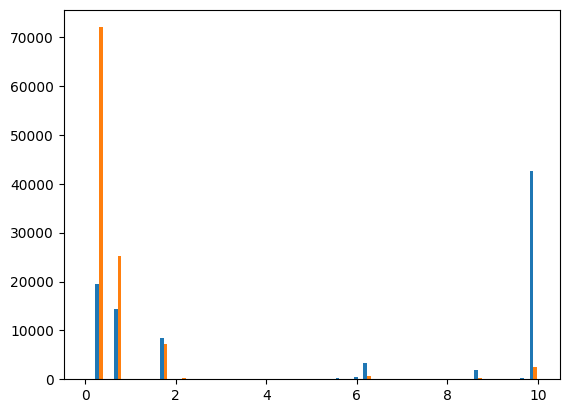

In [13]:
#2d likelihood
bj_2d = copy.deepcopy(bj)
lf_2d = copy.deepcopy(lf)

for i in bj_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

for i in lf_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

res_b = likelihood(bj_2d,counts,bins)
res_lf = likelihood(lf_2d,counts,bins)

for i in range(len(res_b)):
    if res_b[i]>10:
        res_b[i]=10

for i in range(len(res_lf)):
    if res_lf[i]>10:
        res_lf[i]=10
        
plt.hist([res_b,res_lf],bins=np.linspace(0,10,50))

In [14]:
#shuffle
Xzip = list(zip(y,d0))
random.shuffle(Xzip)
y, d0 = list(zip(*Xzip))
#padding
for i in d0:
    while len(i)<5:
        i.append(-99)
    while len(i)>5:
        i.remove(min(i))
#picking out training and test data
y_train = y[0:160000]
y_test = y[160000:200000]
d0_train = d0[0:160000]
d0_test = d0[160000:200000]

d0_train = torch.tensor(d0_train,dtype=torch.float32)
d0_test = torch.tensor(d0_test,dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [15]:

simpleModel = nn.Sequential(
   nn.Linear(5,10),
   nn.Sigmoid(),
   nn.Linear(10,7),
   nn.Sigmoid(),
   nn.Linear(7,5),
   nn.Sigmoid(),
   nn.Linear(5,3),
   nn.Sigmoid(),
   nn.Linear(3,2),
   nn.Sigmoid(),
   nn.Linear(2,1),
   nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer=optim.Adam(simpleModel.parameters(),lr = 0.01)

In [16]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(d0_train), batch_size):
        Xbatch = d0_train[i:i+batch_size]
        y_pred = simpleModel(Xbatch)
        ybatch = y_train[i:i+batch_size]
        #print(y_pred[0], ybatch[0])
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.6377196907997131
Finished epoch 1, latest loss 0.6356908679008484
Finished epoch 2, latest loss 0.635185956954956
Finished epoch 3, latest loss 0.6374748349189758
Finished epoch 4, latest loss 0.6377729773521423
Finished epoch 5, latest loss 0.6372870802879333
Finished epoch 6, latest loss 0.6368375420570374
Finished epoch 7, latest loss 0.6365348696708679
Finished epoch 8, latest loss 0.6368585228919983
Finished epoch 9, latest loss 0.6366956233978271
Finished epoch 10, latest loss 0.6256943345069885
Finished epoch 11, latest loss 0.6262576580047607
Finished epoch 12, latest loss 0.623595118522644
Finished epoch 13, latest loss 0.6203325390815735
Finished epoch 14, latest loss 0.6186572909355164
Finished epoch 15, latest loss 0.6171064376831055
Finished epoch 16, latest loss 0.6159616708755493
Finished epoch 17, latest loss 0.6160631775856018
Finished epoch 18, latest loss 0.6148269176483154
Finished epoch 19, latest loss 0.6146205067634583
Finished epo

Accuracy 0.7529500126838684


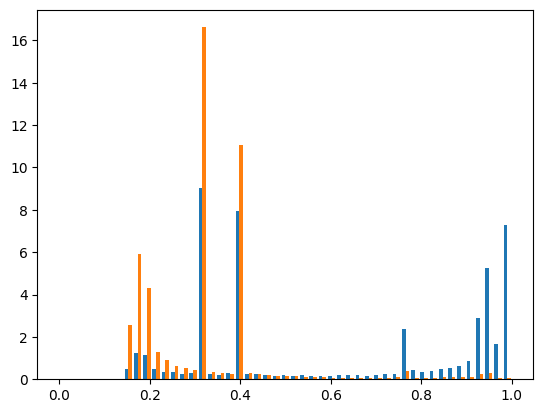

In [17]:
with torch.no_grad():
    y_pred = simpleModel(d0_test)
    #print(y_pred)
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

true=[]
false=[]
y_pred=torch.flatten(y_pred)
y_pred=y_pred.tolist()
for i in range(len(y_test)):
    if y_test[i]==1:
        true.append(y_pred[i])
    else:
        false.append(y_pred[i])
d0Counts,d0bins, _=plt.hist([true,false], bins=np.linspace(0,1,50), density=True)

In [18]:
high_lev_data = data.loc[:,'track_2_d0_significance' : 'n_tracks_over_d0_threshold']


In [19]:
no_inf = data[high_lev_data["track_2_d0_significance"] != (-np.inf or np.inf)]
#infs = data[data["track_2_d0_significance"] == (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_3_d0_significance"] != (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_2_z0_significance"] != (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_3_z0_significance"] != (-np.inf or np.inf)]
print(no_inf.shape)
#print(infs.shape)

(154644, 26)


In [20]:
high_lev_data_smear = no_inf.loc[:,['track_2_d0_significance_smear','track_3_d0_significance_smear','track_2_z0_significance_smear','track_3_z0_significance_smear','n_tracks_over_d0_threshold']]

In [21]:
temp_y=no_inf[2]
temp_y = temp_y.values.tolist()

smeared_data = high_lev_data_smear.to_numpy()
smeared_data_bj=[]
smeared_data_lf=[]
for i in range(len(temp_y)):
    if temp_y[i] == 5:
        smeared_data_bj.append(smeared_data[i])
    else:
        smeared_data_lf.append(smeared_data[i])


In [22]:
high_lev_y = no_inf[2]
high_lev_y = high_lev_y.values.tolist()
for i in range(len(high_lev_y)):
    if high_lev_y[i]==5:
        high_lev_y[i]=1
    else:
        high_lev_y[i]=0

high_lev_x = no_inf[3]
high_lev_x = high_lev_x.values.tolist()
for i in high_lev_x:
    i.pop(-1)
    i.pop(-1)
    i.pop(-1)


In [23]:
high_level_vars_zip = list(zip(high_lev_y,high_lev_x))
random.shuffle(high_level_vars_zip)
high_lev_y, high_lev_x = list(zip(*high_level_vars_zip))

high_lev_x_train = high_lev_x[0:100000]
high_lev_x_test = high_lev_x[100000:len(high_lev_x)]
high_lev_y_train = high_lev_y[0:100000]
high_lev_y_test = high_lev_y[100000:len(high_lev_y)]

highlevelTest_b=[]
highlevelTest_lf=[]

for i in range(len(high_lev_y_test)):
    if high_lev_y_test[i]==1:
        highlevelTest_b.append(high_lev_x_test[i])
    else:
        highlevelTest_lf.append(high_lev_x_test[i])

highlevelTest_b = torch.tensor(highlevelTest_b, dtype=torch.float32)
highlevelTest_lf = torch.tensor(highlevelTest_lf, dtype=torch.float32)

In [24]:
high_lev_y_train = torch.tensor(high_lev_y, dtype=torch.float32).reshape(-1, 1)
high_lev_y_test = torch.tensor(high_lev_y, dtype=torch.float32).reshape(-1, 1)
high_lev_x_train = torch.tensor(high_lev_x, dtype=torch.float32)
high_lev_x_test = torch.tensor(high_lev_x, dtype=torch.float32)

In [25]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(high_lev_x_train), batch_size):
        Xbatch = high_lev_x_train[i:i+batch_size]
        y_pred = simpleModel(Xbatch)
        ybatch = high_lev_y_train[i:i+batch_size]
        #print(y_pred[0], ybatch[0])
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

with torch.no_grad():
    y_pred = simpleModel(high_lev_x_test)
    print(y_pred)
accuracy = (y_pred.round() == high_lev_y_test).float().mean()
print(f"Accuracy {accuracy}")

Finished epoch 0, latest loss 0.36384162306785583
Finished epoch 1, latest loss 0.3450537919998169
Finished epoch 2, latest loss 0.3294834494590759
Finished epoch 3, latest loss 0.34798139333724976
Finished epoch 4, latest loss 0.35471078753471375
Finished epoch 5, latest loss 0.35298609733581543
Finished epoch 6, latest loss 0.3475343883037567
Finished epoch 7, latest loss 0.3428361117839813
Finished epoch 8, latest loss 0.344023197889328
Finished epoch 9, latest loss 0.3492497205734253
Finished epoch 10, latest loss 0.353193074464798
Finished epoch 11, latest loss 0.342720627784729
Finished epoch 12, latest loss 0.3418932259082794
Finished epoch 13, latest loss 0.32908210158348083
Finished epoch 14, latest loss 0.33148834109306335
Finished epoch 15, latest loss 0.33472803235054016
Finished epoch 16, latest loss 0.329682856798172
Finished epoch 17, latest loss 0.3331702649593353
Finished epoch 18, latest loss 0.3322455585002899
Finished epoch 19, latest loss 0.3307636082172394
Finishe

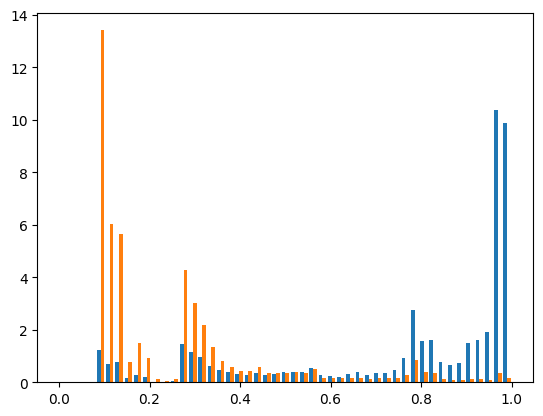

In [26]:
true = simpleModel(highlevelTest_b)
true=torch.flatten(true).tolist()
false = simpleModel(highlevelTest_lf)
false=torch.flatten(false).tolist()

hlCounts,hlbins,_ = plt.hist([true,false], bins=np.linspace(0,1,50), density=True)

In [27]:
smeared_data_bj = torch.tensor(smeared_data_bj, dtype=torch.float32)
smeared_data_lf = torch.tensor(smeared_data_lf, dtype=torch.float32)

pos = simpleModel(smeared_data_bj)
pos=torch.flatten(pos).tolist()
neg = simpleModel(smeared_data_lf)
neg=torch.flatten(neg).tolist()

/var/folders/vg/yfv452x11j97tr10qw3gk5440000gn/T/ipykernel_68603/181100295.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  smeared_data_bj = torch.tensor(smeared_data_bj, dtype=torch.float32)


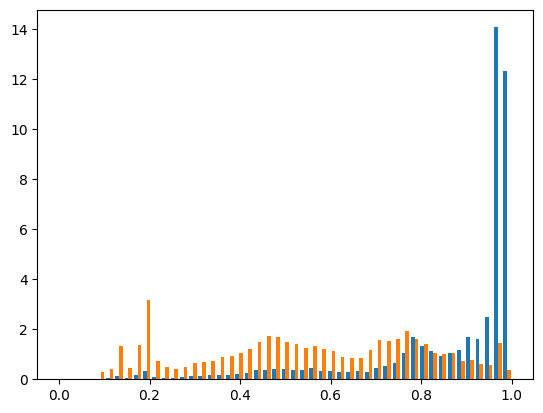

In [28]:

smearCounts,smearbins,_=plt.hist([pos,neg], bins=np.linspace(0,1,50), density=True)

[0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9750097341687018, 0.9606739584439488, 0.9445329368871898, 0.9409932391773741, 0.9351173409790803, 0.9307989097731053, 0.9305511309334182, 0.9300555732540441, 0.9292768397578846, 0.8993309971328447, 0.8761459771335527, 0.8567130367066653, 0.8437577430887402, 0.8338819864783547, 0.8258468726770734, 0.8191568440055219, 0.8134933276698169, 0.8059183745708116, 0.8002194612580085, 0.7939187993345367, 0.786060670418746, 0.7779547626632686, 0.7697426639764964, 0.7583802343279884, 0.7526459240380872, 0.7476903472443452, 0.7432303281299777, 0.7371066510919968, 0.7293547131075007, 0.7239389756114827, 0.7164702134437719, 0.7088952603447665, 0.6991964886198718, 0.6802945028494567, 0.6241195001946833, 0.5916958691727727, 0.5584581076776043, 0.5430604226399065, 0.529290998548724, 0.5144242681674984, 0.48412445577147706, 0.45152383986407557, 0.41258716505610415, 0.20123181480301583]
[0.99999999999999

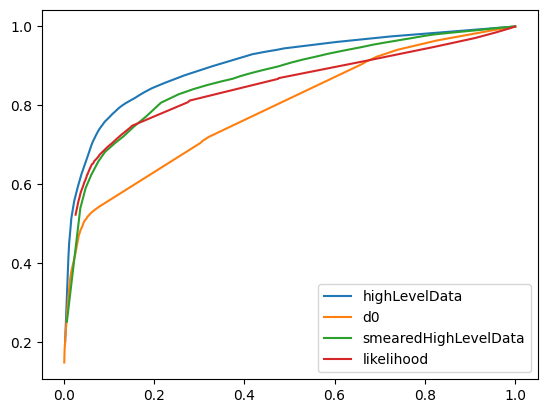

In [29]:
aucHL=pltROCnAUC(hlCounts,hlbins,"highLevelData")
aucd0=pltROCnAUC(d0Counts,d0bins,"d0")
aucSmear=pltROCnAUC(smearCounts,smearbins,"smearedHighLevelData")
likelihoodArea=pltROCnAUC(llhcounts,llhbins,"likelihood")
print(-likelihoodArea)

print(-aucHL)
print(-aucd0)